# Introduction

Our notebooks have been initialized thanks to several sources provided around the Home Credit default risk [Kaggle](https://www.kaggle.com/c/home-credit-default-risk) competition: data from Home Credit, Kernels-Notebooks from competitors, Discussions threads involving host and competitors.

While the objective of competitors is to get the best AUC score _Area under the ROC Curve_ by *__any means__*, we'll rather focuse on the ability to provide *__interpretable__* decisions, including the possibility given to customers to explore their case.

# Notebooks & dashboard

There are 4 different notebooks:
* __P7_EDA__: focusing on Exploratory Data Analysis,
* __P7_FE__: focusing on Feature engineering and a first model-agnostic Feature Selection,
* __Current: P7_FS__: focusing on scoring with model evaluation,
* __P7_Interpretation__ : focusing on model interpretation,
And a dashboard python file.

# Forewords
In this FS notebook, we process a model-agnostic Feature Selection in order to focus on valuable features. There are many alternate techniques, we just found this one interesting to get to a truncated dataset and provide models of any kind with the same inputs. We could as well consider doing a more accurate feature selection step dedicated to the best model found.

In [1]:
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from BorutaShap import BorutaShap

In [3]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999

## Result of Feature Engineering

In [4]:
with open("Data/application_miss.pkl", mode="rb") as df:
    application = pickle.load(df)

In [5]:
# keep training applications only
train = application[application['TARGET'].notna()]

In [6]:
# set index with SK_ID_CURR
train = train.set_index('SK_ID_CURR')

# "Model agnostic" Boruta Feature Selection

In [7]:
# isolate target
X_ = train.drop(columns=['TARGET'])
y_ = train['TARGET']

In [8]:
del train

In [9]:
# sampling if test
X_sample, _, y_sample, _ = train_test_split(
        X_,
        y_,
        stratify=y_,
        test_size=0.8,
        random_state=42)

In [10]:
# impute strategy 'mean' ! introduce a dependency
imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value=0)
imputer.fit(X_sample)
X_sample = imputer.transform(X_sample)

In [11]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1,
                            class_weight='balanced',
                            max_depth=6)

In [12]:
# define Boruta feature selection method
feat_selector = BorutaPy(rf,
                         n_estimators='auto',
                         max_iter=25,
                         verbose=2,
                         random_state=1)

In [13]:
# find all relevant features - features should be selected
feat_selector.fit(X_sample, y_sample)

Iteration: 	1 / 25
Confirmed: 	0
Tentative: 	940
Rejected: 	0
Iteration: 	2 / 25
Confirmed: 	0
Tentative: 	940
Rejected: 	0
Iteration: 	3 / 25
Confirmed: 	0
Tentative: 	940
Rejected: 	0
Iteration: 	4 / 25
Confirmed: 	0
Tentative: 	940
Rejected: 	0
Iteration: 	5 / 25
Confirmed: 	0
Tentative: 	940
Rejected: 	0
Iteration: 	6 / 25
Confirmed: 	0
Tentative: 	940
Rejected: 	0
Iteration: 	7 / 25
Confirmed: 	0
Tentative: 	940
Rejected: 	0
Iteration: 	8 / 25
Confirmed: 	265
Tentative: 	108
Rejected: 	567
Iteration: 	9 / 25
Confirmed: 	265
Tentative: 	108
Rejected: 	567
Iteration: 	10 / 25
Confirmed: 	265
Tentative: 	108
Rejected: 	567
Iteration: 	11 / 25
Confirmed: 	265
Tentative: 	108
Rejected: 	567
Iteration: 	12 / 25
Confirmed: 	268
Tentative: 	77
Rejected: 	595
Iteration: 	13 / 25
Confirmed: 	268
Tentative: 	77
Rejected: 	595
Iteration: 	14 / 25
Confirmed: 	268
Tentative: 	77
Rejected: 	595
Iteration: 	15 / 25
Confirmed: 	268
Tentative: 	77
Rejected: 	595
Iteration: 	16 / 25
Confirmed: 	269


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=6,
                                          n_estimators=425, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x266A7DD9158),
         max_iter=25, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x266A7DD9158, verbose=2)

In [17]:
# create df feature ranking & store
features = application.set_index('SK_ID_CURR').drop(columns=['TARGET']).columns
ranks = feat_selector.ranking_
with open("Data/boruta_ranking.pkl", mode="wb") as array:
    pickle.dump(ranks, array)
df = pd.DataFrame({'feature': features, 'rank': ranks})
df = df.sort_values(by=['rank'], ascending=True)

In [24]:
df = pd.DataFrame({'feature': features, 'rank': ranks})

In [26]:
df = df.sort_values(by=['rank'], ascending=True)

In [27]:
type(df)

pandas.core.frame.DataFrame

In [28]:
df.to_csv('Data/boruta_ranking.csv')

In [20]:
# get support features and filter resulting dataset & store
support = application.set_index('SK_ID_CURR').drop(columns=['TARGET']).columns[feat_selector.support_]
with open("Data/boruta_support.pkl", mode="wb") as cols:
    pickle.dump(support, cols)
selected = []
selected = ['SK_ID_CURR'] + ['TARGET'] + support.tolist()
sel_app = application.filter(selected)
with open("Data/sel_app.pkl", mode="wb") as df:
    pickle.dump(sel_app, df)

In [21]:
sel_app

,SK_ID_CURR,TARGET,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,...,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_VAR,N_CC_USE_LATE_MONTH_6,N_CC_USE_LATE_MONTH_2
0,100002,1.0,1,202500.0,406597.5,24700.5,351000.0,0.018801,-637.0,-3648.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1188.0,-1186.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,1,67500.0,135000.0,6750.0,135000.0,0.010032,-225.0,-4260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-3039.0,-9833.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,100007,0.0,1,121500.0,513000.0,21865.5,513000.0,0.028663,-3038.0,-4311.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,456221,NaN,0,121500.0,412560.0,17473.5,270000.0,0.002042,-5169.0,-9094.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,456222,NaN,0,157500.0,622413.0,31909.5,495000.0,0.035792,-1149.0,-3015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,456223,NaN,0,202500.0,315000.0,33205.5,315000.0,0.026392,-3037.0,-2681.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,456224,NaN,1,225000.0,450000.0,25128.0,450000.0,0.018850,-2731.0,-1461.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
del sel_app
del application

## Boruta Shap : perspective
from BorutaShap import BorutaShap
Feature_Selector = BorutaShap(importance_measure='shap',
                              classification=False)
Feature_Selector.fit(X=X_, y=y_, n_trials=100, random_state=0)

In [20]:
with open("Data/sel_app.pkl", mode="rb") as df:
    sel_app = pickle.load(df)

In [29]:
# isolate target
train = sel_app[sel_app['TARGET'].notna()]
# set index with SK_ID_CURR
train = train.set_index('SK_ID_CURR')
X_ = train.drop(columns=['TARGET'])
y_ = train['TARGET']

In [30]:
# sampling if test
X_sample, _, y_sample, _ = train_test_split(
        X_,
        y_,
        stratify=y_,
        test_size=0.99,
        random_state=42)

In [31]:
del X_
del y_

In [32]:
X_sample.fillna(0, inplace=True)

In [37]:
X_sample.head(1)

,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,...,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_VAR,N_CC_USE_LATE_MONTH_6,N_CC_USE_LATE_MONTH_2
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
229273,0,72000.0,490495.5,27517.5,454500.0,0.018634,-1258.0,-4716.0,-1151,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
X_filter = X_sample.loc[:, X_sample.columns.str.contains('CC_')]

In [52]:
Feature_Selector = BorutaShap(importance_measure='shap', classification=True)

In [53]:
X_filter.shape

(3075, 19)

In [54]:
Feature_Selector.fit(X=X_filter, y=y_sample, n_trials=15, random_state=0)

  0%|                                                                                           | 0/15 [02:52<?, ?it/s]


KeyboardInterrupt: 

In [47]:
from BorutaShap import BorutaShap, load_data
  
X, y = load_data(data_type='regression')
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [48]:
# no model selected default is Random Forest, if classification is True it is a Classification problem
Feature_Selector = BorutaShap(importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=X, y=y, n_trials=100, random_state=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:29<00:00,  3.89s/it]

10 attributes confirmed important: ['TAX', 'INDUS', 'B', 'DIS', 'NOX', 'LSTAT', 'CRIM', 'AGE', 'PTRATIO', 'RM']
3 attributes confirmed unimportant: ['ZN', 'RAD', 'CHAS']
0 tentative attributes remains: []


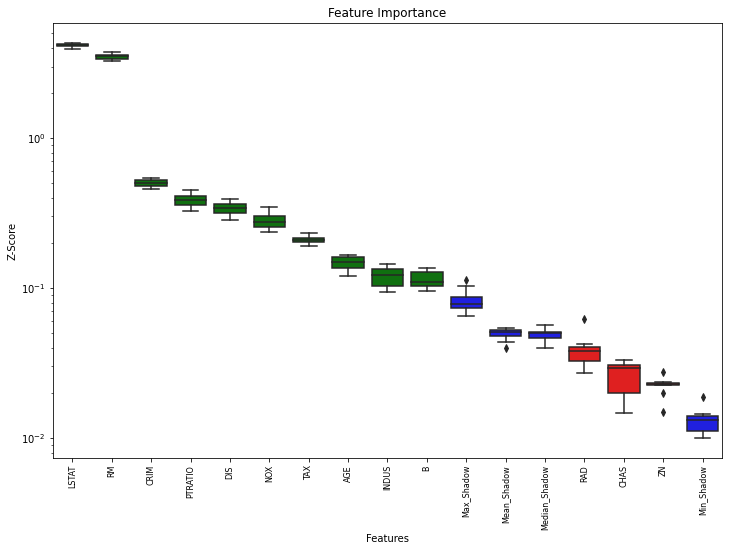

In [49]:
# Returns Boxplot of features
Feature_Selector.plot(which_features='all', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

In [50]:
# Returns a subset of the original data with the selected features
subset = Feature_Selector.Subset()
subset.head()

,TAX,INDUS,B,DIS,NOX,LSTAT,CRIM,AGE,PTRATIO,RM
0,296.0,2.31,396.90,4.0900,0.538,4.98,0.00632,65.2,15.3,6.575
1,242.0,7.07,396.90,4.9671,0.469,9.14,0.02731,78.9,17.8,6.421
2,242.0,7.07,392.83,4.9671,0.469,4.03,0.02729,61.1,17.8,7.185
3,222.0,2.18,394.63,6.0622,0.458,2.94,0.03237,45.8,18.7,6.998
4,222.0,2.18,396.90,6.0622,0.458,5.33,0.06905,54.2,18.7,7.147


In [51]:
subset.shape

(506, 10)